# Part II: Data Processing and Order Book Construction

## Import the packages and load the data

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('btc_usd.csv', header = 0, index_col = 0)
df.datetime = [np.datetime64(df.datetime[i]) for i in range(len(df))]

## Make the order book
Subtract the information from the tick data to construct the order book which reflects the information of market trading decisions and deals.
Major variables:
- `self.book`: The dictionary which documents the existing orders with the keys being the prices and the values being the volumes;
- `self.prices`: The ascending list which documents all the prices of the existing orders; 
- `self.best_bid` and `self.best_ask`: The index of the position of the best bid and ask prices in `self.prices`. When all the orders are bids, `self.best_bid = -1`; when all the orders are asks, `self.best_ask = len(self.prices)`. With these position indicator, we could easily distinguish the ask orders and bid orders in `self.book`.

Every time and order is placed, the object take in the information which includes:
- `price`: The price of the order, which is a positive real number;
- `volume`: The volume of the order;
- `direction`: the indicator of sell (-1) or buy (1).

In [884]:
class order_book(object):
    def __init__(self):
        # initialize the book
        self.best_bid = -1
        self.best_ask = 0
        self.book = None
        self.prices = None
        self.epsilon = 10 ** (-8)

    def add_order(self, price, volume, direction):
        # the actual deal prices which the new order triggers
        actual_price = []
        
        # when the first order comes..
        if (self.book is None):
            self.book = {price: volume}
            self.prices = [price]
            if (direction == 1):
                self.best_bid = 0
                self.best_ask = 1
            return 0, actual_price

        # when all the orders are asks
        if (self.best_bid < 0):
            if (direction == -1):
                if (price in self.prices):
                    self.book[price] += volume
                else:
                    self.book[price] = volume
                    self.prices.append(price)
                    self.prices.sort()
                return 0, actual_price

        # when all the orders are bids
        if (self.best_ask == len(self.prices)):
            if (direction == 1):
                if (price in self.prices):
                    self.book[price] += volume
                else:
                    self.book[price] = volume
                    self.prices.append(price)
                    self.prices.sort()
                    self.best_ask += 1
                    self.best_bid += 1
                return 0, actual_price

        # add a buy order to the book
        if (direction == 1) and (price < self.prices[self.best_ask]):
            if (price in self.prices):
                self.book[price] += volume
            else:
                self.book[price] = volume
                self.prices.append(price)
                self.prices.sort()
                self.best_bid += 1
                self.best_ask += 1
            return 0, actual_price

        # add a sell order to the book
        if (direction == -1) and (price > self.prices[self.best_bid]):
            if (price in self.prices):
                self.book[price] += volume
            else:
                self.book[price] = volume
                self.prices.append(price)
                self.prices.sort()
            return 0, actual_price

        if (direction == 1) and (price >= self.prices[self.best_ask]):
            dvol = min(volume, self.book[self.prices[self.best_ask]])
            self.book[self.prices[self.best_ask]] -= dvol
            volume -= dvol
            actual_price.append(self.prices[self.best_ask])

            while True:
                # the order has been absorbed
                if (volume < self.epsilon):
                    break

                self.book.pop(self.prices[self.best_ask])
                self.prices.pop(self.best_ask)

                # the order penetrates all the asks
                if (self.best_ask == len(self.prices)):
                    if (volume != 0):
                        self.prices.append(price)
                        self.book[price] = volume
                        self.best_bid += 1
                        self.best_ask += 1
                    break

                # the order fails to go any further
                if (price < self.prices[self.best_ask]):
                    self.book[price] = volume
                    self.prices.append(price)
                    self.prices.sort()
                    self.best_ask += 1
                    self.best_bid += 1
                    break

                dvol_0 = min(volume, self.book[self.prices[self.best_ask]])
                self.book[self.prices[self.best_ask]] -= dvol_0
                volume -= dvol_0
                dvol += dvol_0
                actual_price.append(self.prices[self.best_ask])

            return dvol, actual_price

        if (direction == -1) and (price <= self.prices[self.best_bid]):
            dvol = min(volume, self.book[self.prices[self.best_bid]])
            self.book[self.prices[self.best_bid]] -= dvol
            volume -= dvol
            actual_price.append(self.prices[self.best_bid])

            while True:
                # the order has been absorbed
                if (volume < self.epsilon):
                    break

                self.book.pop(self.prices[self.best_bid])
                self.prices.pop(self.best_bid)
                self.best_ask -= 1
                self.best_bid -= 1

                # the order penetrates all the bids
                if (self.best_bid < 0):
                    if (volume != 0):
                        self.prices.insert(0, price)
                        self.book[price] = volume
                    self.best_bid = -1
                    self.best_ask = 0
                    break

                # the order fails to go any further
                if (price > self.prices[self.best_bid]):
                    self.book[price] = volume
                    self.prices.append(price)
                    self.prices.sort()
                    break

                dvol_0 = min(volume, self.book[self.prices[self.best_bid]])
                self.book[self.prices[self.best_bid]] -= dvol_0
                volume -= dvol_0
                dvol += dvol_0
                actual_price.append(self.prices[self.best_bid])

            return dvol, actual_price

    def brief(self):
        # print out the information regarding the market orders
        briefing = ''
        for (i, price) in enumerate(self.prices):
            if (i <= self.best_bid):
                briefing += ('Bid: ' + str(price) + '; vol: ' + str(self.book[price])) + '\n'
            else:
                briefing += ('Ask: ' + str(price) + '; vol: ' + str(self.book[price])) + '\n'
        return briefing

Let's conduct a simple test to see how this orderbook works...

In [883]:
my_order_book_test = order_book()

my_order_book_test.add_order(100, 50, 1)
print('First test:')
print(my_order_book_test.brief())

my_order_book_test.add_order(110, 150, 1)
print('Second test:')
print(my_order_book_test.brief())

my_order_book_test.add_order(120, 80, 1)
print('Third test:')
print( my_order_book_test.brief())

my_order_book_test.add_order(125, 50, -1)
print('Fourth test:')
print(my_order_book_test.brief())

my_order_book_test.add_order(115, 150, -1)
print('Fifth test:')
print(my_order_book_test.brief())

my_order_book_test.add_order(95, 500, -1)
print('Sixth test:')
print(my_order_book_test.brief())

First test:
Bid: 100; vol: 50

Second test:
Bid: 100; vol: 50
Bid: 110; vol: 150

Third test:
Bid: 100; vol: 50
Bid: 110; vol: 150
Bid: 120; vol: 80

Fourth test:
Bid: 100; vol: 50
Bid: 110; vol: 150
Bid: 120; vol: 80
Ask: 125; vol: 50

Fifth test:
Bid: 100; vol: 50
Bid: 110; vol: 150
Ask: 115; vol: 70
Ask: 125; vol: 50

Sixth test:
Ask: 95; vol: 300
Ask: 115; vol: 70
Ask: 125; vol: 50



## Use the order book to process the tick data

In [ ]:
sb = {'buy': 1, 'sell': -1}
sb[df.type[0]]

dt = np.timedelta64('60', 's')
i = 0
t0 = df.datetime[i]
t1 = t0 + dt

prices = pd.DataFrame(columns = ['open', 'close', 'high', 'low', 'vol'])
my_order_book = order_book()

while i < len(df):
    temp_prices = []
    temp_volume = []
    while df.datetime[i] < t1:
        (temp_temp_volume, temp_temp_prices) = my_order_book.add_order(df.price[i], df.quantity[i], sb[df.type[i]])
        temp_volume.append(temp_temp_volume)
        temp_prices += temp_temp_prices
        i += 1
    try:
        prices.loc[t0] = [temp_prices[0], temp_prices[-1], max(temp_prices), min(temp_prices), sum(temp_volume)]
    except:
        price = prices.close[t0 - dt]
        prices.loc[t0] = [price, price, price, price, 0]
    t0 += dt
    t1 += dt

### A visualization of the distribution of an intermediate stage of the order book

<BarContainer object of 360 artists>

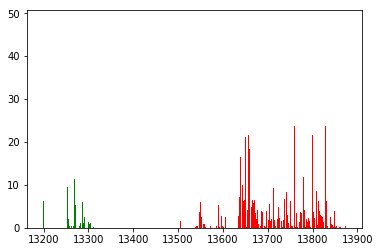

In [898]:
from matplotlib import pyplot as plt
%matplotlib inline

b_prices = my_order_book.prices[:my_order_book.best_bid]
a_prices = my_order_book.prices[my_order_book.best_ask:]

b_sizes = [my_order_book.book[price] for price in b_prices]
a_sizes = [my_order_book.book[price] for price in a_prices]

plt.bar(b_prices, b_sizes,color = 'g')
plt.bar(a_prices, a_sizes,color = 'r')

An overlook of how the OHLC-Volume data looks like...

In [886]:
print(prices.head(10))
np.save('prices.npy', np.array(prices))

                        open    close     high      low        vol
2018-01-01 00:00:01  13763.0  13765.0  13788.0  13763.0   1.886770
2018-01-01 00:01:01  13765.0  13746.0  13765.0  13741.0   5.706395
2018-01-01 00:02:01  13746.0  13741.0  13750.0  13741.0   3.742622
2018-01-01 00:03:01  13741.0  13735.0  13741.0  13735.0   3.804955
2018-01-01 00:04:01  13735.0  13734.0  13735.0  13734.0   7.086961
2018-01-01 00:05:01  13734.0  13564.0  13734.0  13559.0  30.757124
2018-01-01 00:06:01  13559.0  13570.0  13570.0  13559.0   6.221985
2018-01-01 00:07:01  13570.0  13581.0  13581.0  13570.0  13.681397
2018-01-01 00:08:01  13581.0  13615.0  13615.0  13581.0  11.861682
2018-01-01 00:09:01  13615.0  13634.0  13636.0  13607.0  25.698492
